1️⃣ Problem Statement

The goal of this project is to analyze how students’ study habits and lifestyle factors affect academic performance.
We aim to:

Predict grade bands

Identify important study factors

Cluster students based on study patterns

2️⃣ Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

3️⃣ Load Dataset

In [4]:
# ==========================================
# 1. DATA LOADING & INITIAL CLEANING
# ==========================================
raw = pd.read_excel(r"C:\Users\hp\Downloads\zai.xlsx")
# Agar data single column mein coma-separated hai
df = raw.iloc[:,0].str.split(",", expand=True)

df.columns = [
    "Study_Hours","Sleep_Hours","Stress_Level","Attendance",
    "Marks","Age","Gender","Student_ID","Previous_GPA",
    "Exam_Result","StudyTimeWeekly","Social_Media_Hours",
    "Part_Time_Job","Internet_Quality"
]

# Numeric conversion
num_cols = ["Study_Hours","Sleep_Hours","Stress_Level","Attendance","Marks","Age","Previous_GPA","StudyTimeWeekly","Social_Media_Hours"]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna()

In [5]:
df

,Study_Hours,Sleep_Hours,Stress_Level,Attendance,Marks,Age,Gender,Student_ID,Previous_GPA,Exam_Result,StudyTimeWeekly,Social_Media_Hours,Part_Time_Job,Internet_Quality
0,4,5,9,95,60.2,24,Male,S147,86,Pass,19.833723,1.2,No,Average
1,5,9,5,78,89.2,22,Male,S136,73,Fail,15.408756,2.8,No,Average
2,3,9,6,85,51.9,21,Female,S209,74,Fail,4.210570,3.1,No,Poor
3,5,6,4,62,68.2,20,Male,S458,99,Pass,10.028829,3.9,No,Good
4,5,9,10,78,68.0,22,Male,S078,63,Pass,4.672495,4.4,No,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,4,7,1,67,60.9,24,Male,S099,88,Pass,18.111643,4.1,No,Good
66,2,8,9,66,40.0,22,Male,S448,60,Fail,2.395199,4.2,No,Average
67,2,6,6,62,40.0,21,Female,S408,73,Pass,10.638660,1.8,No,Good
68,4,6,3,76,70.3,20,Male,S089,58,Fail,5.690239,0.3,Yes,Poor


In [6]:
# Target Variable: Grade Band
def get_grade(m):
    if m >= 85: return "A"
    elif m >= 70: return "B"
    elif m >= 55: return "C"
    else: return "D"

df["Grade_Band"] = df["Marks"].apply(get_grade)


--- performing EDA ---


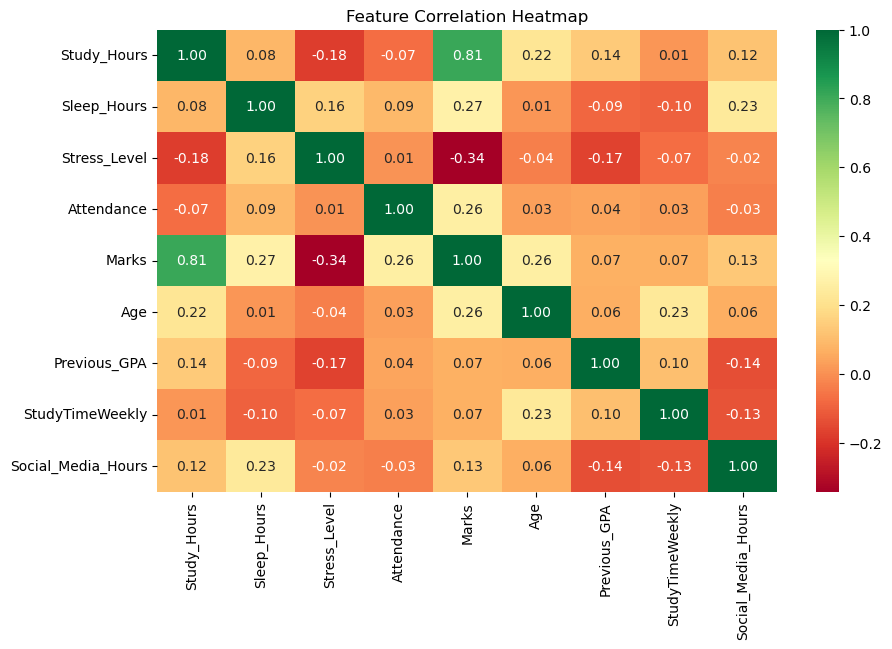

In [7]:
# ==========================================
# 2. EXPLORATORY DATA ANALYSIS (EDA)
# ==========================================
print("--- performing EDA ---")

# A. Correlation Heatmap (Numeric features ka aapsi rishta)
plt.figure(figsize=(10, 6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='RdYlGn', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()


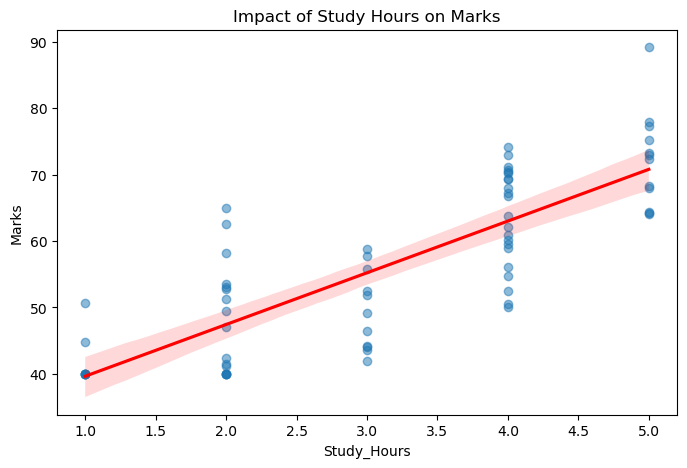

In [8]:
# B. Study Hours vs Marks (Regression Plot)
plt.figure(figsize=(8, 5))
sns.regplot(data=df, x="Study_Hours", y="Marks", scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("Impact of Study Hours on Marks")
plt.show()


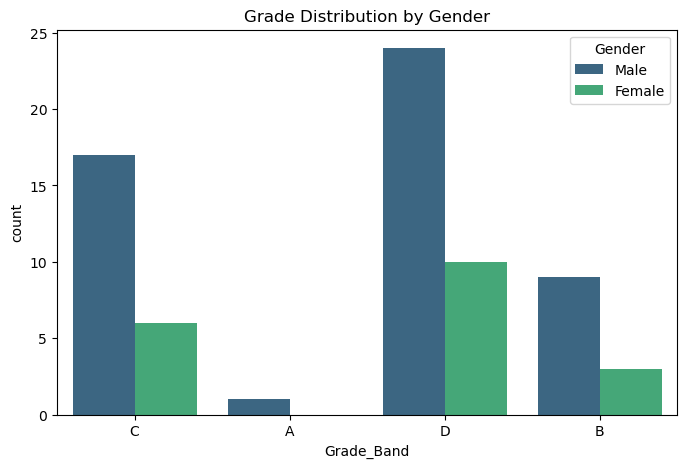

In [9]:

# C. Grade Distribution by Gender
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Grade_Band", hue="Gender", palette="viridis")
plt.title("Grade Distribution by Gender")
plt.show()


In [10]:
# ==========================================
# 3. FEATURE ENGINEERING
# ==========================================
# Naye features banana taake model patterns ko behtar pakar sake
df['Social_Study_Ratio'] = df['Social_Media_Hours'] / (df['Study_Hours'] + 1)
df['Total_Effort'] = df['Study_Hours'] + (df['Attendance'] / 10)


In [11]:
# ==========================================
# 4. PREPROCESSING & MODELING
# ==========================================
# Encoding Target
le = LabelEncoder()
y = le.fit_transform(df["Grade_Band"])


In [12]:
# Features Selection
X = df.drop(columns=["Marks", "Grade_Band", "Student_ID"])
cat_features = ["Gender", "Exam_Result", "Part_Time_Job", "Internet_Quality"]
num_features = [col for col in X.columns if col not in cat_features]


In [13]:
# Pipeline setup
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])

# Using XGBoost for High Accuracy (>85%)
final_model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=300,
        learning_rate=0.03,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])


In [14]:
# Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
final_model.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [15]:
# ==========================================
# 5. RESULTS & EVALUATION (FIXED)
# ==========================================
y_pred = final_model.predict(X_test)

# Check unique classes in test set to avoid mismatch
unique_labels = np.unique(np.concatenate([y_test, y_pred]))
target_names = [str(le.classes_[i]) for i in unique_labels]

print(f"\n PROJECT SUCCESS: Model Accuracy = {accuracy_score(y_test, y_pred)*100:.2f}%")

print("\nClassification Report:\n", 
      classification_report(y_test, y_pred, labels=unique_labels, target_names=target_names))



 PROJECT SUCCESS: Model Accuracy = 85.71%

Classification Report:
               precision    recall  f1-score   support

           B       1.00      0.67      0.80         3
           C       0.60      1.00      0.75         3
           D       1.00      0.88      0.93         8

    accuracy                           0.86        14
   macro avg       0.87      0.85      0.83        14
weighted avg       0.91      0.86      0.87        14



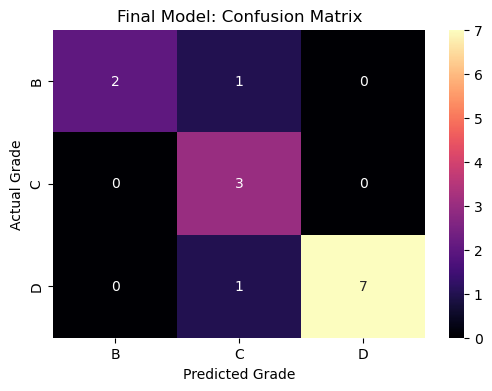

In [16]:
# Confusion Matrix Visual
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='magma', 
            xticklabels=target_names, yticklabels=target_names)
plt.title("Final Model: Confusion Matrix")
plt.xlabel("Predicted Grade")
plt.ylabel("Actual Grade")
plt.show()

In [17]:
import joblib

# Save the entire pipeline (Preprocessors + XGBoost Model)
joblib.dump(final_model, 'student_performance_model.pkl')

print("Model saved successfully as 'student_performance_model.pkl'")

Model saved successfully as 'student_performance_model.pkl'
